# Оценка успешности сдачи школьного экзамена<a id="main">

* [Введение](#intro)
* [Формирование гипотез](#hypo)
* [EDA](#EDA)
* [Проверка гипотез](#check)


## Введение<a id='intro'>
[Оглавление](#main)

В качестве исходных данных взят датасет с Kaggle о [результатах сдачи экзаменов](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students/) у обучающихся разных школ.<br>
Данный датасет собран по реальным данным, но все персональные данные заменены на произвольные названия. Уникальность сохранена.

Основная цель исследования будет заключаться в том, чтобы выяснить зависимости результатов экзаменов от места обучения, количества человек в классе, результатов предварительного тестирования и т.д.

In [1]:
# если модуль kaggle отсутствует в системе, раскомментировать:
# !pip install kaggle

import os
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison
%matplotlib inline


In [2]:
data_path_name = 'data'

os.system("kaggle datasets download kwadwoofosu/predict-test-scores-of-students -f test_scores.csv -p " + data_path_name)

DATA_PATH = Path('./' + data_path_name)
DATASET = DATA_PATH / 'test_scores.csv'


## Формирование гипотез<a id='hypo'>
[Оглавление](#main)

1. Зависимость результатов экзамена от пола кажется сомнительной, но все же для убеждения в этом следует оценить такую гипотезу строго


2. Важно знать, эффективно ли проведено обучение в приницпе, для этого результаты предварительного тестирования должны быть хуже, чем результаты контрольного тестирования. Проверим этот случай.


3. Каждое учебное учреждение обладает рядом особенностей. Проверим, одинков ли средний балл в зависимости от:
    * типа школы (открытая, частная)
    * расположения (городская, сельская)
    * метода преподавания (стандартный, экспериментальный)
    * наличия бесплатных/льготных обедов в школе


4. Для сравнения эффективности разных школ проверим предположения о том, что в каждой школе средний балл за экзамен будет одинаков. Провести ранжировку школ при отрицательном результате предыдущего пункта.

## EDA<a id='EDA'>
[Оглавление](#main)

Перед началом нужно понять, с какими данными придется дальше иметь дело:

In [3]:
df = pd.read_csv(DATASET)
df.sample(5, random_state=10)


,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
1725,VHDHF,Rural,Non-public,KR1,Experimental,15.0,M0EE2,Male,Qualifies for reduced/free lunch,54.0,70.0
1884,VVTVA,Urban,Public,A93,Experimental,30.0,NU14D,Female,Qualifies for reduced/free lunch,31.0,48.0
920,IDGFP,Urban,Non-public,XZM,Standard,17.0,6OF17,Female,Does not qualify,72.0,79.0
1143,LAYPA,Rural,Public,RA5,Experimental,17.0,I115S,Female,Does not qualify,60.0,78.0
1865,VVTVA,Urban,Public,A93,Experimental,30.0,2MA9Q,Male,Qualifies for reduced/free lunch,34.0,51.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


Все значения определены и у нас нет пропусков. Какой приятный сюрприз!


Итак, наш датасет состоит из:
* `school` - название школы
* `school_setting` - расположение школы
* `school_type` - критерий доступности школы (открытая/частная)
* `classroom` - название класса, в котором сдается экзамен (не информативен в данном случае)
* `teaching_method` - метод обучения (делится на обычный и экспериментальный)
* `n_student` - количество обучающихся в классе
* `student_id` - номер студента (не информативен в данном случае)
* `gender` - пол ученика
* `lunch` - возможность получить льготный или бесплатный обед в школе
* `pretest` - результаты предварительного тестирования
* `posttest` - результаты окончательного тестирования

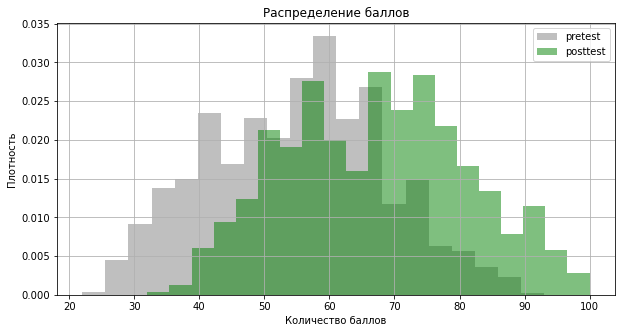

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(df.pretest, bins=20, alpha=0.5, color='grey', label='pretest', density=True)
plt.hist(df.posttest, bins=20, alpha=0.5, color='green', label='posttest', density=True)
plt.legend(loc='best')
plt.title('Распределение баллов')
plt.ylabel('Плотность')
plt.xlabel('Количество баллов')
plt.grid()
plt.show()


Заметно, что результаты финального тестирования находятся правее, чем результаты предварительного тестирования. Далее узнаем, будет ли это различие статистически значимым. Также распределение человек визуально похоже на нормальное, что можно проверить более строго, предполагая, что шанс ошибиться у не превосходит 0.05:

In [6]:
_, p_pre =  stats.normaltest(df.pretest)
_, p_post = stats.normaltest(df.posttest)

print(f'p-value для pretest: {p_pre}\np-value для posttest: {p_post}')


p-value для pretest: 1.400086621526593e-17
p-value для posttest: 1.2530847479792289e-27


Что означает, что действительно можно принимать распределение этих признаков как нормальное, т.к. оно меньше выбранного порога в 0.05.

Часть данных нам не пригодится, можем сразу их удалить. Также для категориальных признаков оценим уникальное количество их значений и постараемся сгруппировать те, которые близки по смыслу или малочисленны:

In [7]:
df.drop(columns=['classroom', 'student_id'], inplace=True)

In [8]:
cat_columns = df.columns[df.dtypes == 'object']
print('Уникальные значения в категориях:')
print(f'\n  {"Имя признака:":21}Кол-во:\tПеречень значений:')
for clm in cat_columns:
    val_cnt = df[clm].value_counts()
    print(f'  {clm + ":":21}{val_cnt.count()}\t{val_cnt.keys().to_list() if val_cnt.count() < 5 else ""}')
    

Уникальные значения в категориях:

  Имя признака:        Кол-во:	Перечень значений:
  school:              23	
  school_setting:      3	['Urban', 'Suburban', 'Rural']
  school_type:         2	['Public', 'Non-public']
  teaching_method:     2	['Standard', 'Experimental']
  gender:              2	['Male', 'Female']
  lunch:               2	['Does not qualify', 'Qualifies for reduced/free lunch']


## Проверка гипотез<a id="check">
[Оглавление](#main)

Далее будем считать, что уровень значимости в проверке гипотез равен 0.05

In [9]:
alpha = 0.05


### 1.
Для оценки такого рода гипотезы возьмем 2 выборки с группировкой по полю `gender`, т.е. применим дисперсный анализ и проверим гипотезу о равенстве средних $H_0: \overline y_1 = \overline y_2$.<br>
Для этого воспользуемся $T$ статистикой Фишера, показывающей отношение несмещенных дисперсий межгрупповой к внутригрупповой:
$$T = \frac{\sigma^2_b}{\sigma^2_w}$$
, где $\sigma_b^2 = \dfrac{SS_b^2}{k - 1}, \sigma_{w}^2 = \dfrac{SS_{w}^2}{n - k}$, в то время, как $SS_b^2$ и $SS_w^2$ показывают сумму квадратов отклонений межгрупповую и остаточную соответственно и равны $SS_b^2 = \displaystyle\sum_{i=1}^k (\overline{y}_i - \overline{y})^2 n_i, SS_{w}^{2} = \displaystyle\sum_{i=1}^k \displaystyle\sum_{j=1}^{n_i} (y_{ij} - \overline{y}_i)^2$ в случае, когда $k$ показывает количество групп, а $n_i$ - количество наблюдений в $i$ группе, при этом $n = \displaystyle\sum_{i=1}^k n_i$.<br>
Далее по выбранному уровню значимости рассчитаем критическое значение статистики Фишера и примем решение о подтверждении или опровержении нашей гипотезы:

In [10]:
def split_in_group(X, groupby, target):
    '''
    Делит выборку X по значениям группы groupby в колонке target
    '''
    groups = []
    for val in X[groupby].value_counts().keys():
        groups.append(X.loc[X[groupby] == val, target])
    return groups

def SS2_b(groups):
    '''
    Расчет суммы квадратов отклонений средних групповых значений
    '''
    y_mean = np.hstack(groups).mean()
    SS2_b = 0
    for y in groups:
        n_i = len(y)
        SS2_b += ((y.mean() - y_mean)**2) * n_i
    return SS2_b

def SS2_w(groups):
    '''
    Расчет остаточных сумм квадратов отклонений средних в группах
    '''
    SS2_w = 0
    for y in groups:
        SS2_w += ((y - y.mean())**2).sum()
    return SS2_w
    
def sigma2(SS2, n, ddof):
    return SS2 / (n - ddof)

def F_crit(alpha, k1, k2):
    return stats.f.ppf(1 - alpha, k1, k2)

def Fisher_criteria(alpha, X, groupby, target):
    n = len(X)
    groups = split_in_group(X, groupby, target)
    k = len(groups)
    SS2_b_, SS2_w_ = SS2_b(groups), SS2_w(groups)
    T = sigma2(SS2_b_, k, 1) / sigma2(SS2_w_, n, k)
    k1 = k - 1
    k2 = n - k
    return T, F_crit(alpha, k1, k2)


In [11]:
T, F_cr = Fisher_criteria(alpha, df, 'gender', 'posttest')
print(f'T критерий равен {round(T, 4)}, критическое значение F - {round(F_cr, 4)}')


T критерий равен 0.1015, критическое значение F - 3.8458


T-критерий получился меньше критического значения F. Это означает, что в средних результатах мальчиков и девочек нет статистически значимых различий, таким образом можно сделать вывод, что пол если и влияет на результаты экзамена, то незначительно. 

### 2.
Для проверки гипотезы можно найти доверительные интервалы для результатов самого экзамена для заданного уровня доверия (по уровню значимости) и оценить, попадает ли в них интервал для результатов предварительного тестирования. Конечно, можно рассматривать задачу так же с точки зрения дисперсионного анализа, но в текущем случае мы получим разброс, в котором может находиться искомое среднее для обоих признаков, что будет полезным для дальнейших исследований.<br><br>
Найдем интервал распределения Стюьдента для представленного случая:

$$P(t_{\alpha/2, n - 1} \leq T \leq t_{1 - \alpha/2, n - 1}) = p$$
$$P(t_{\alpha/2, n - 1} \leq \frac{M_x - \mu}{\sigma_x / \sqrt n} \leq t_{1 - \alpha/2, n - 1}) = p$$
$$P(M_x + t_{\alpha/2, n - 1} \cdot \frac{\sigma_x}{\sqrt n} \leq \mu\leq M_x + t_{1 - \alpha/2, n - 1}\cdot \frac{\sigma_x}{\sqrt n}) = p$$

In [12]:
t1, t2 = stats.t.ppf(alpha / 2, df=df.shape[0]), stats.t.ppf(1 - alpha / 2, df=df.shape[0])

M_x, std = df.posttest.mean(), df.posttest.std(ddof=1)
M_interval = (round(M_x + t1 * std / df.shape[0]**0.5, 4), round(M_x + t2 * std / df.shape[0]**0.5, 4))
print(f'Доверительный интервал для мат. ожидания результатов итогового экзамена: {M_interval} при среднем в {round(M_x, 4)}')


Доверительный интервал для мат. ожидания результатов итогового экзамена: (66.5083, 67.6961) при среднем в 67.1022


In [13]:
M_x, std = df.pretest.mean(), df.pretest.std(ddof=1)
M_interval = (round(M_x + t1 * std / df.shape[0]**0.5, 4), round(M_x + t2 * std / df.shape[0]**0.5, 4))
print(f'Доверительный интервал для мат. ожидания результатов тестового экзамена: {M_interval} при среднем в {round(M_x, 4)}')


Доверительный интервал для мат. ожидания результатов тестового экзамена: (54.38, 55.5318) при среднем в 54.9559


Полученные интервалы не пересекаются, что дает сделать вывод о том, выдвинутую гипотезу можно отклонить и считать, что результат на итоговом экзамене у учащихся выше, чем на тестовом.

### 3.
Ряд текущих гипотез будет использовать для проверки ту же методологию, что и в первой но группировку будет проводить по иным признакам:

In [14]:
features = ['school_setting', 'school_type', 'teaching_method', 'lunch']

for feature in features:
    print(feature)
    T, F_cr = Fisher_criteria(alpha, df, feature, 'posttest')
    print(f'T критерий равен {round(T, 4)}, критическое значение F - {round(F_cr, 4)}', end='. ')
    if T < F_cr:
        print('Гипотеза подтверждается. Различия статистически не значимые')
    else:
        print('Гипотеза отклоняется. Различия статистически значимые')
    print('---------------------------------------------')

school_setting
T критерий равен 284.6449, критическое значение F - 2.9999. Гипотеза отклоняется. Различия статистически значимые
---------------------------------------------
school_type
T критерий равен 346.3698, критическое значение F - 3.8458. Гипотеза отклоняется. Различия статистически значимые
---------------------------------------------
teaching_method
T критерий равен 231.2568, критическое значение F - 3.8458. Гипотеза отклоняется. Различия статистически значимые
---------------------------------------------
lunch
T критерий равен 1188.5615, критическое значение F - 3.8458. Гипотеза отклоняется. Различия статистически значимые
---------------------------------------------


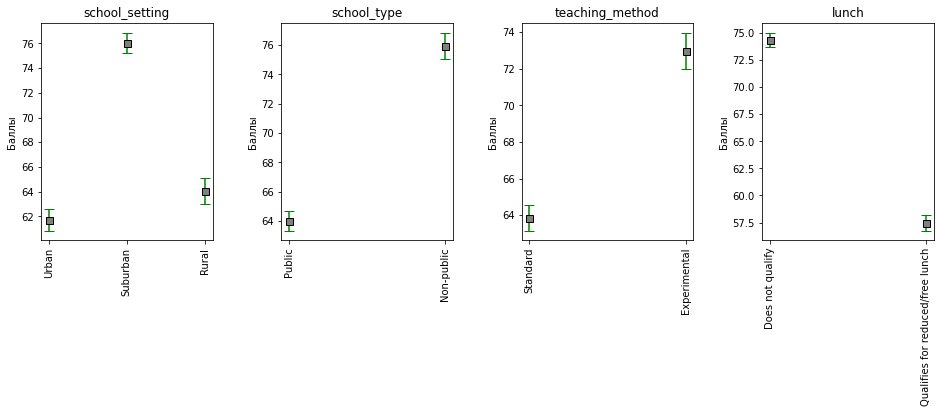

In [15]:
M_x, err, values = dict(), dict(), dict()
for feature in features:
    M_x[feature], err[feature] = [], []
    values[feature] = df[feature].value_counts().keys().to_list()
    for group in values[feature]:
        X = df.loc[df[feature] == group, 'posttest']
        M_x[feature].append(X.mean())
        std = X.std(ddof=1)
        t = stats.t.ppf(1 - alpha / 2, df=X.shape[0])
        err[feature].append(t * std / X.shape[0]**0.5)

fig, axes = plt.subplots(ncols=len(values))
plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(4 * len(values), 4)
axes = axes.flatten()

for key, ax in zip(values.keys(), axes):    
    x_ticks = values[key]
    ox = np.arange(0, len(values[key]))

    oy = M_x[key]

    oerr = err[key]

    ax.errorbar(x=ox, y=oy, yerr=oerr, color="green", capsize=5,
                 linestyle="None",
                 marker="s", markersize=7, mfc="grey", mec="black")

    ax.set_xticks(ox)
    ax.set_xticklabels(x_ticks, rotation=90)
    
    ax.set_title(key)
    ax.set_ylabel('Баллы')

Таким образом видно, что больше всего баллов по отдельности набрали ученики:
   * обучающиеся в школах, расположенных в населенных пунктах городского типа
   * обучающиеся в частных школах
   * которым преподавали по экспериментальному методу
   * обучающиеся в школах, где нет привелегий по питанию/бесплатного питания (неожиданно)

### 4.


Для подтверждения или опровержения гипотезы проведем дисперсионных анализ по выбранному полю и оценим результат:

In [16]:
T, F_cr = Fisher_criteria(alpha, df, 'school', 'posttest')
print(f'T критерий равен {round(T, 4)}, критическое значение F - {round(F_cr, 4)}')

T критерий равен 367.3403, критическое значение F - 1.5471


Действительно, как и ожидалось, результаты получились статистически значимыми. Но этот исход достаточно ожидаемый из-за того, что хотя бы одна пара из возможного числа комбинаций 2 из всех школ имела бы достаточно большие различия между средними баллами.<br>
Для получения более полезных результатов и лучшей наглядности хочется сравнить все пары между собой, однако сравнивать их все напрямую чревато ростом ошибки ложно отрицательных случаев из-за вероятности быть в какой-то из множества сравнений случайно выбранных нетипичных в выборке значений. Иными словами, делая какое-либо вычисление много раз, мы только накапливаем ошибку.

Пересоберем данные с группировкой по названию школы и построим график средних значений результатов экзаменов с разметкой 95% доверительных интервалов:

In [17]:
df_schools = df[['school', 'posttest']].groupby('school').agg(['mean', 'std', 'count'])
df_schools.reset_index(inplace=True)
df_schools.columns = ['school', 'mean', 'std', 'n']
df_schools.sort_values('mean', ascending=False, inplace=True)
df_schools['f'] = df_schools['std'] / df_schools.n**0.5 * stats.t.ppf(1 - alpha / 2, df=df_schools.n-1)


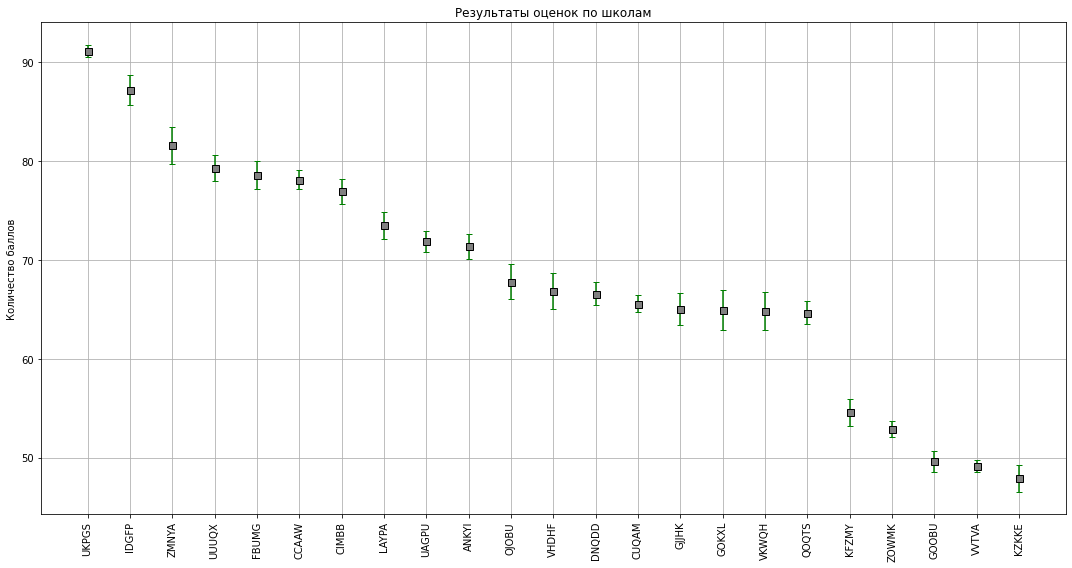

In [18]:
plt.figure(figsize=(15,8))
x_ticks = df_schools.school.unique()

x_1 = np.arange(df_schools.shape[0])

y_1 = df_schools['mean']

err_1 = df_schools['f']

plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="green", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="grey", mec="black")
plt.xticks(x_1, x_ticks, rotation=90)
plt.title('Результаты оценок по школам')
plt.ylabel('Количество баллов')
plt.grid()
plt.tight_layout()
plt.show()

О статистической значимости гипотезы можно делать выводы только в случае, если интервалы для двух рассматриваемых пар школ не будут пересекаться.

Таким образом видно, что среднее количество баллов за экзамен для школы UKPGS наибольшее, несколько отстает от нее IDGFP. После них расположилась достаточно плотная группа "средних", но в конце отчетливо видны 5 отстающих.

Для более подробного анализа между любыми двумя школами можно воспользоваться следующими результатами по критерию Тьюки:

In [19]:
MultiComp = MultiComparison(df.posttest, df.school, group_order=df.school.unique())

df_p = MultiComp.tukeyhsd().summary()
df_p

group1,group2,meandiff,p-adj,lower,upper,reject
ANKYI,CCAAW,6.7198,0.001,2.4764,10.9633,True
ANKYI,CIMBB,5.5557,0.0019,1.0463,10.0651,True
ANKYI,CUQAM,-5.8295,0.001,-10.0837,-1.5752,True
ANKYI,DNQDD,-4.8247,0.0064,-9.0058,-0.6435,True
ANKYI,FBUMG,7.2185,0.001,2.2438,12.1931,True
ANKYI,GJJHK,-6.3648,0.001,-10.5638,-2.1659,True
ANKYI,GOKXL,-6.4371,0.001,-11.0704,-1.8038,True
ANKYI,GOOBU,-21.7763,0.001,-25.8359,-17.7167,True
ANKYI,IDGFP,15.8332,0.001,11.4982,20.1681,True
ANKYI,KFZMY,-16.8133,0.001,-21.6509,-11.9758,True
